![](http://)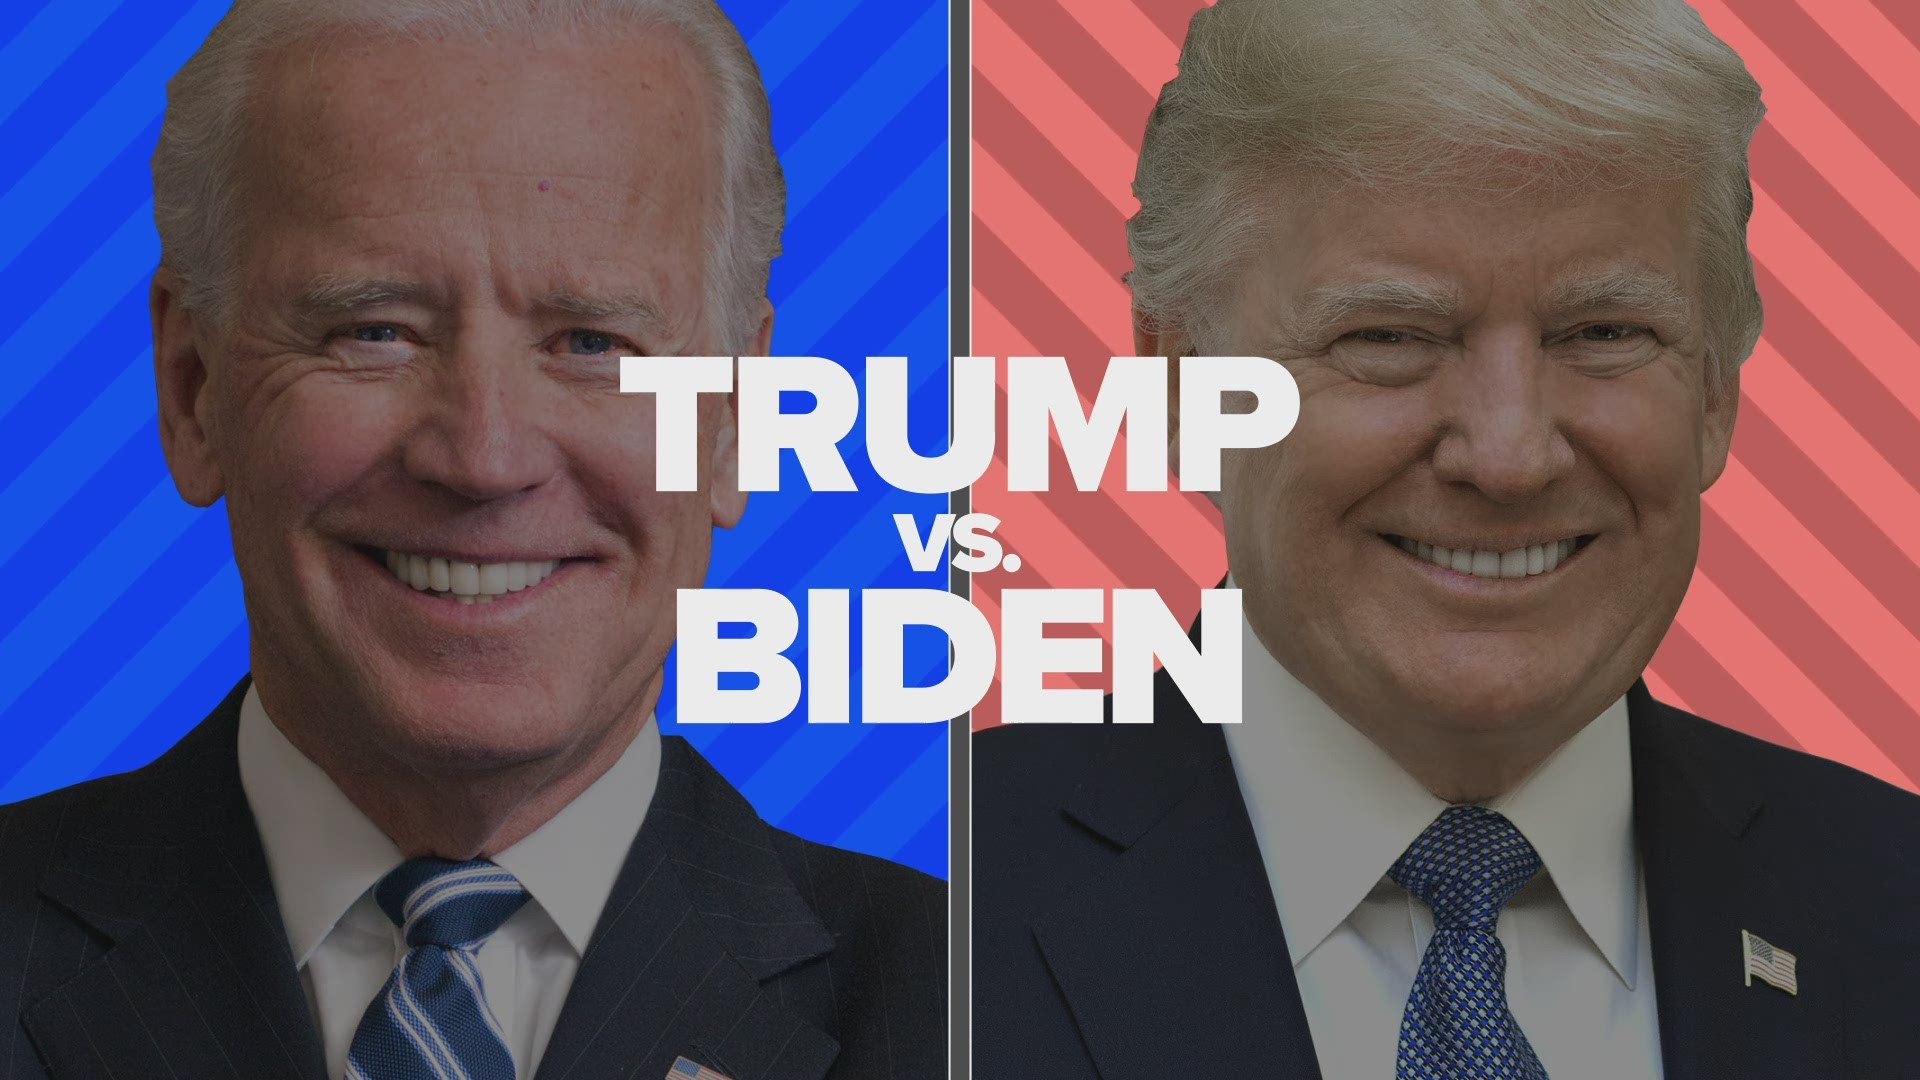

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import io
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
Trump_dataset = pd.read_csv('/kaggle/input/us-election-2020-tweets/hashtag_donaldtrump.csv', lineterminator='\n')
Biden_dataset = pd.read_csv('../input/us-election-2020-tweets/hashtag_joebiden.csv',lineterminator='\n')

In [ ]:
Trump_dataset.head()

In [ ]:
Biden_dataset.head()

In [ ]:
# Drop useles columns
Trump_dataset = Trump_dataset.drop(columns = ['tweet_id','collected_at','user_description','collected_at'])
Biden_dataset = Biden_dataset.drop(columns = ['tweet_id','collected_at','user_description','collected_at'])

In [ ]:
Trump_dataset.loc[:,'condidat'] = 'Trump'
Biden_dataset.loc[:,'condidat'] = 'Biden'

In [ ]:
Data_Mixed = pd.concat([Trump_dataset,Biden_dataset])
Data_Mixed.sort_values(by='created_at')
Data_Mixed.head()

In [ ]:
Trump_tweets = Data_Mixed.query('(condidat == "Trump")').tweet.sort_values(ascending=False).count()
Biden_tweets = Data_Mixed.query('(condidat == "Biden")').tweet.sort_values(ascending=False).count()

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [Trump_tweets,Biden_tweets]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of tweets')
plt.title('Donald vs Biden')

plt.show()

In [ ]:
Trump_tweets = Data_Mixed.query('(condidat == "Trump")').likes.count()
Biden_tweets = Data_Mixed.query('(condidat == "Biden")').likes.count()

objects = ('Donald Trump','Joe Biden')
y_pos = np.arange(len(objects))
performance = [Trump_tweets,Biden_tweets]

plt.bar(y_pos, performance, align='center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of Likes')
plt.title('Donald vs Biden')

plt.show()

In [ ]:
def Country_tweets(country,kind):
    Data=Data_Mixed[Data_Mixed.country == country].groupby('condidat').tweet.count()
    Data.plot(x = 'condidate',y = "tweet",kind = kind, title="tweets count in country " + str(country))
    
Country_tweets('Germany','pie')

In [ ]:
Country_tweets('Brazil','bar')

In [ ]:
Country_tweets('India','pie')

# Create class for chart building.

In [ ]:
class Chart_builder:
    
    def __init__(self,topic_index,number):
        super().__init__()
        self.topic_index = topic_index
        self.topics_list = ['source','country','state','continent','city']
        self.number      = number
        self.index = self.topics_list[self.topic_index]
        self.Trump_tweets_sources_x = Data_Mixed.query('(condidat == "Trump")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number].index
        
        self.Trump_tweets_sources_y = Data_Mixed.query('(condidat == "Trump")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number]
        
        self.Biden_tweets_sources_x = Data_Mixed.query('(condidat == "Biden")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number].index
        
        self.Biden_tweets_sources_y = Data_Mixed.query('(condidat == "Biden")').groupby(by = self.index).count().tweet.sort_values(ascending = False)[:self.number]
    
    def Builder(self):
        fig = go.Figure([go.Bar(x = self.Trump_tweets_sources_x, y = self.Trump_tweets_sources_y, name = 'Trump'),
                         go.Bar(x = self.Biden_tweets_sources_x, y = self.Biden_tweets_sources_y, name = 'Biden')])
        # Customize aspect
        fig.update_layout(title_text = 'top '+ str(self.number) + ' ' + self.index)
        fig.update_xaxes(title = 'sources')
        fig.update_yaxes(title = 'tweets count')
        fig.show()

****Example of class usage****

In [ ]:
# choose index for topic
topic_index = 1 # from class list its country

# number of elements in chart
number = 5 # it;s mean top five

launch = Chart_builder(topic_index,number)
launch.Builder()

# 1
topic_index = 0
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()
# 2
topic_index = 2
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()
#3
topic_index = 3
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()
#4
topic_index = 4
number = 10 
launch = Chart_builder(topic_index,number)
launch.Builder()


# SENTINMENT ANALYSIS 
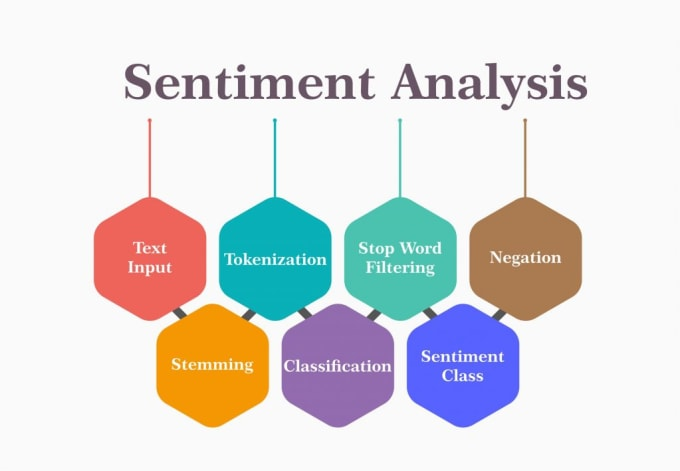

# Functions for Data Manipulation

In [ ]:
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    return text

In [ ]:
# create fuction to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score==0:
        return 'neutral'
    else:
        return 'positive'

# DONALD TRUMP

In [ ]:
Trump_Tweets = Data_Mixed.query('(condidat == "Trump")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Trump_Tweets = Trump_Tweets.dropna().loc[Trump_Tweets.country == 'United States of America'][:1000]


Trump_Tweets.reset_index(inplace = True, drop = True)

Trump_Tweets['ClearTweet'] = Trump_Tweets['tweet'].apply(clean)

Trump_Tweets['subjectivity']= Trump_Tweets['ClearTweet'].apply(getSubjectivity)
Trump_Tweets['polarity']    = Trump_Tweets['ClearTweet'].apply(getPolarity)
Trump_Tweets['analysis']    = Trump_Tweets['polarity'].apply(getAnalysis)
Trump_Tweets.head()


Trump_Tweets.head()

In [ ]:
%%time
Trump_Tweets.polarity = Trump_Tweets.polarity.apply(lambda x: getAnalysis(x))

In [ ]:
from collections import Counter

target_cnt = Counter(Trump_Tweets.polarity)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
general  = Trump_Tweets.groupby('analysis').analysis.count()
neutral  = Trump_Tweets[Trump_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = Trump_Tweets[Trump_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = Trump_Tweets[Trump_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='sentimat analysis tweets Donald Trump')
fig.show()

# Joe Biden

In [ ]:
Biden_Tweets = Data_Mixed.query('(condidat == "Biden")').sort_values('user_followers_count',ascending = False).drop_duplicates(['user_name'])[['tweet','country']]
Biden_Tweets = Biden_Tweets.dropna().loc[Biden_Tweets.country == 'United States of America'][:1000]


Biden_Tweets.reset_index(inplace = True, drop = True)

Biden_Tweets['ClearTweet'] = Biden_Tweets['tweet'].apply(clean)

 
Biden_Tweets['subjectivity']= Biden_Tweets['ClearTweet'].apply(getSubjectivity)
Biden_Tweets['polarity']    = Biden_Tweets['ClearTweet'].apply(getPolarity)
Biden_Tweets['analysis']    = Biden_Tweets['polarity'].apply(getAnalysis)
Biden_Tweets.head()


Biden_Tweets.head()

In [ ]:
%%time
Biden_Tweets.polarity = Biden_Tweets.polarity.apply(lambda x: getAnalysis(x))

In [ ]:
target_cnt = Counter(Biden_Tweets.polarity)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
general  = Biden_Tweets.groupby('analysis').analysis.count()
neutral  = Biden_Tweets[Biden_Tweets['analysis'] == 'neutral'].ClearTweet.count()
positive = Biden_Tweets[Biden_Tweets['analysis'] == 'positive'].ClearTweet.count()
negative = Biden_Tweets[Biden_Tweets['analysis'] == 'negative'].ClearTweet.count()

fig = go.Figure(data = [go.Funnelarea(labels = ["positivity","negativity","neutrality"], values = [positive,negative,neutral])])
fig.update_layout(title_text ='sentimat analysis tweets Joe Biden')
fig.show()